## Investigating The Causes of JAMB Failure Rates and Predicting Future Performance Trends (2020–2030)
Over the past five years, there has been a noticeable increase in the failure rate of students taking the Joint Admissions and Matriculation Board (JAMB) examination in Nigeria. This project aims to investigate the root causes of this trend through data-driven research and analysis. We will design and conduct a survey to gather relevant data, explore this data to identify key insights, build a predictive model to forecast success and failure rates over the next five years (2026–2030), and provide actionable recommendations to mitigate future failure rates.

### Predictive Modeling
Here, we will build a supervised machine learning model to:
1. Predict the likelihood of a student's success or failure in the JAMB exam.
2. Forecast aggregate success and failure rates from 2026 to 2030.

### Import required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### 1. Likelihood of a Student's Success or Failure in the JAMB Exam(2026-2030)

In [17]:
# Load Dataset
df = pd.read_excel('JAMB_Survey_Data.xlsx')
df_cleaned = df.copy()

# Clean Column Names
df_cleaned.columns = df_cleaned.columns.str.strip()
for col in df_cleaned.select_dtypes(include='object').columns:
    df_cleaned[col] = df_cleaned[col].map(lambda x: x.strip() if isinstance(x, str) else x)

# Renaming Columns
df_cleaned.columns = [
    "Gender", "Email", "Age", "Exam_Year", "State", "School_Type", "JAMB_Score",
    "Preferred_Course", "Met_Cutoff", "Prep_Method", "Study_Hours", "Family_Income",
    "Internet_Access", "CBT_Practice_Frequency", "CBT_Device", "Confidence_Level",
    "Center_Equipped", "Resources_Provided", "Exam_Day_Challenges", "Score_Reflection",
    "Poor_Performance_Reasons", "Suggestions"
    ]

# Convert age ranges to numeric values
age_map = {
    "15 and below": 15,
    "16-17": 16.5,
    "18-19": 18.5,
    "20-21": 20.5,
    "22 and above": 22
}
df_cleaned["Age_Estimate"] = df_cleaned["Age"].map(age_map)

# Convert study hours to numeric
def convert_study_hours(x):
    if isinstance(x, str):
        x = x.strip().lower()
        if "0-1" in x or "less than" in x:
            return 1
        elif "2-3" in x:
            return 2.5
        elif "4-5" in x:
            return 4.5
        elif "6+" in x or "more than 6" in x:
            return 6.5
    return None

df_cleaned["Study_Hours_Num"] = df_cleaned["Study_Hours"].apply(convert_study_hours)

# Create target column
df_cleaned["Passed_JAMB"] = df_cleaned["JAMB_Score"].apply(lambda x: 1 if x >= 200 else 0)

# Select relevant features and drop rows with missing values
model_df = df_cleaned[[
    "Age_Estimate", "Study_Hours_Num", "School_Type", "Prep_Method",
    "Internet_Access", "CBT_Practice_Frequency", "Confidence_Level", "Passed_JAMB"
]].dropna()

# One-hot encode categorical features
model_df = pd.get_dummies(model_df, columns=[
    "School_Type", "Prep_Method", "Internet_Access", "CBT_Practice_Frequency"
])

# Define input (X) and target (y)
X = model_df.drop("Passed_JAMB", axis=1)
y = model_df["Passed_JAMB"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


### Model Evaluation

In [23]:
print("✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))
print("\n✅ Accuracy Score:")
print(accuracy_score(y_test, y_pred))

✅ Confusion Matrix:
[[11  5]
 [ 5  5]]

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        16
           1       0.50      0.50      0.50        10

    accuracy                           0.62        26
   macro avg       0.59      0.59      0.59        26
weighted avg       0.62      0.62      0.62        26


✅ Accuracy Score:
0.6153846153846154


In [27]:
print("Clasification of possible result outcome")

print("0 means Fail")
print("1 means pass")
print("Accuracy score of the Model is 62%")

Clasification of possible result outcome
0 means Fail
1 means pass
Accuracy score of the Model is 62%


### 2. Forecasted aggregate success and failure rates from 2026 to 2030.

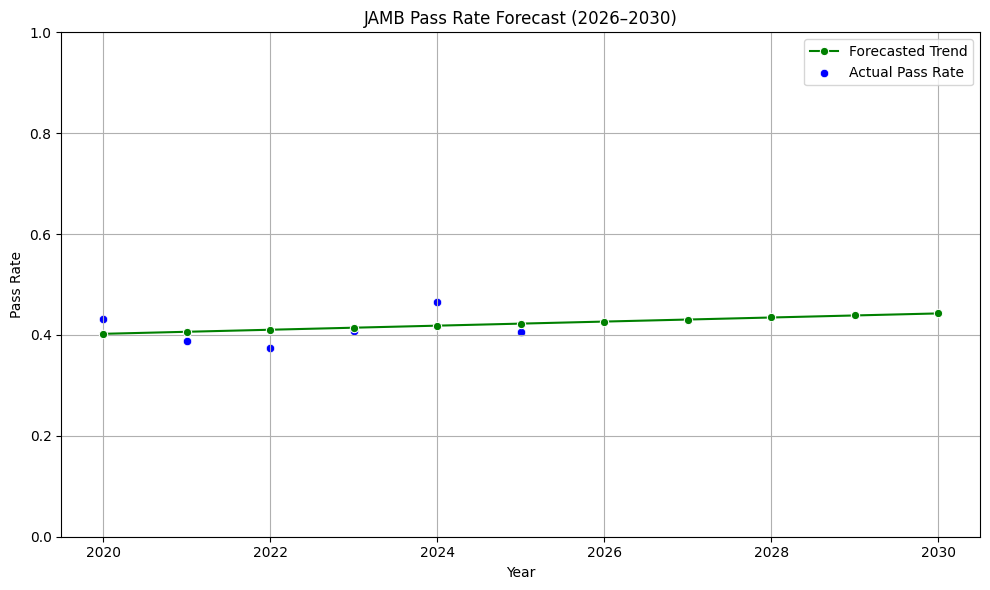

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

# Load Dataset
df = pd.read_excel('JAMB_Survey_Data.xlsx')
df_cleaned = df.copy()

# Clean column names
df_cleaned.columns = df_cleaned.columns.str.strip()
for col in df_cleaned.select_dtypes(include='object').columns:
    df_cleaned[col] = df_cleaned[col].map(lambda x: x.strip() if isinstance(x, str) else x)

# Create binary pass column
df_cleaned["Passed_JAMB"] = df_cleaned["What was your highest JAMB UTME score in any of the years you took the exam?"].apply(lambda x: 1 if x >= 200 else 0)

# Rename the year column
df_cleaned = df_cleaned.rename(columns={"Year(s) you took the JAMB UTME": "Exam_Year"})

# 1. Group by year and calculate pass rate
yearly_summary = df_cleaned.groupby("Exam_Year")["Passed_JAMB"].mean().reset_index()
yearly_summary.columns = ["Year", "Pass_Rate"]

# 2. Train linear regression model
X = yearly_summary[["Year"]]
y = yearly_summary["Pass_Rate"]

model = LinearRegression()
model.fit(X, y)

# 3. Predict pass rates for 2026–2030
future_years = pd.DataFrame({"Year": np.arange(2026, 2031)})
future_pass_rates = model.predict(future_years)

# Combine all for plotting
all_years = pd.concat([yearly_summary, future_years], ignore_index=True)
all_years["Predicted_Pass_Rate"] = model.predict(all_years[["Year"]])

# 4. Plot actual vs predicted pass rates
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_years, x="Year", y="Predicted_Pass_Rate", label="Forecasted Trend", marker="o", color="green")
sns.scatterplot(data=yearly_summary, x="Year", y="Pass_Rate", label="Actual Pass Rate", color="blue")
plt.title("JAMB Pass Rate Forecast (2026–2030)")
plt.ylabel("Pass Rate")
plt.xlabel("Year")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Recommendations for Improving JAMB Performance Outcomes

Based on the findings from the data analysis and predictive modeling, the following data-backed recommendations are proposed for students, educators, and policymakers to improve JAMB performance outcomes:

#### For Students:
1. **Early Preparation**:
   - **Start Early**: Begin preparing for the JAMB exam at least six months in advance. This allows ample time to cover the syllabus comprehensively and revise effectively.
   - **Consistent Study Schedule**: Develop and adhere to a consistent study schedule, dedicating at least 3-4 hours per day to preparation in the months leading up to the exam.

2. **Utilize Multiple Resources**:
   - **Diverse Study Materials**: Use a variety of study materials, including textbooks, online platforms (e.g., YouTube, CBT practice sites), and past JAMB questions.
   - **Coaching Centers**: Consider enrolling in reputable coaching centers that offer structured preparation programs and mock exams.

3. **Practice with CBT**:
   - **Regular CBT Practice**: Regularly practice using Computer-Based Testing (CBT) platforms to become familiar with the exam format and reduce anxiety on exam day.
   - **Simulate Exam Conditions**: Practice under conditions that simulate the actual exam environment, including time constraints and using a computer.

4. **Time Management**:
   - **Effective Time Management**: Allocate specific time slots for different subjects and topics, ensuring balanced preparation across all areas.
   - **Avoid Cramming**: Avoid last-minute cramming and focus on understanding concepts rather than memorizing information.

5. **Mental Health and Well-being**:
   - **Stress Management**: Engage in stress-relief activities such as exercise, meditation, or hobbies to manage exam-related anxiety.
   - **Seek Support**: Do not hesitate to seek support from teachers, peers, or counselors if feeling overwhelmed or stressed.

#### For Educators:
1. **Enhanced Coaching Programs**:
   - **Comprehensive Tutoring**: Offer comprehensive tutoring programs that cover the entire JAMB syllabus and provide personalized support to students.
   - **Regular Assessments**: Conduct regular assessments and mock exams to track student progress and identify areas needing improvement.

2. **Technical Training**:
   - **Computer Literacy**: Ensure students are proficient in using computers and navigating CBT platforms. Incorporate computer literacy training into the curriculum if necessary.
   - **Familiarization with CBT**: Provide students with access to CBT practice platforms and encourage regular practice to build confidence and reduce anxiety.

3. **Mental Health Support**:
   - **Counseling Services**: Offer counseling services to help students manage exam-related stress and anxiety.
   - **Workshops on Stress Management**: Conduct workshops on stress management techniques to equip students with coping strategies.

4. **Resource Allocation**:
   - **Study Materials**: Ensure students have access to a wide range of study materials, including textbooks, past JAMB questions, and online resources.
   - **Study Groups**: Encourage the formation of study groups to foster collaborative learning and peer support.

#### For Policymakers:
1. **Resource Allocation**:
   - **Exam Center Improvements**: Allocate resources to improve exam center conditions, including better ventilation, adequate seating, and reliable power supply.
   - **Technical Infrastructure**: Invest in modernizing technical infrastructure to reduce the incidence of computer malfunctions and login problems during the exam.

2. **Policy Adjustments**:
   - **Cut-off Marks**: Consider adjusting cut-off marks to accommodate diverse student capabilities and reduce the pressure on students to achieve high scores.
   - **Exam Policies**: Review and update exam policies to ensure fairness and transparency, and to address any systemic issues that may affect student performance.

3. **Data-Driven Decisions**:
   - **Analytics for Policy**: Use data analytics to inform policy decisions and identify areas needing intervention. Regularly review performance trends and adjust policies accordingly.
   - **Feedback Mechanisms**: Establish feedback mechanisms to gather insights from students, educators, and exam administrators to continuously improve the exam process.

4. **Public Awareness Campaigns**:
   - **Exam Preparation Guidance**: Launch public awareness campaigns to provide students and parents with guidance on effective exam preparation strategies.
   - **Mental Health Awareness**: Promote mental health awareness and provide resources to help students manage exam-related stress.

### Conclusion
Implementing these recommendations can significantly enhance JAMB performance outcomes by addressing key challenges identified through data analysis. By fostering a supportive and well-equipped environment, students can better prepare for the exam, leading to improved performance and increased access to tertiary education opportunities.